<a href="https://colab.research.google.com/github/vphcap-res/DOA_deep_learning/blob/main/DOA_Deep_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install requirements**

In [1]:
import os
print(os.listdir())  # List all files in the current directory

['.config', 'requirements.txt', 'DOA-managed.xlsx', 'sample_data']


In [4]:
# Install the dependencies from requirements.txt
!pip install -r /content/requirements.txt

# Verify that packages are installed
!pip freeze

  Using cached https://pypi.nvidia.com/cudf-cu12/cudf_cu12-24.10.1-cp310-cp310-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (24.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.1/515.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 GB 410.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.5/661.5 kB 33.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did

# **Data prep**

In [5]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import os

In [6]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [7]:
# Ensure deterministic TensorFlow behavior
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [8]:
# Assuming the uploaded file is named 'DOA-managed.xlsx'
df = pd.read_excel('DOA-managed.xlsx')

In [9]:
# Select relevant columns
columns_to_select = ['distance', 'head', 'age', 'meanbw', 'temp', 'season', 'timegr', 'timetrans_min', 'lairagetime', 'classdoa']
df2 = df[columns_to_select]

In [10]:
# Encode the target variable (classdoa)
label_encoder = LabelEncoder()
df2.loc[:, 'classdoa'] = label_encoder.fit_transform(df2['classdoa'])
target = to_categorical(df2['classdoa'])  # One-hot encode the target variable

In [11]:
# Perform stratified splitting before preprocessing
predictors = df2.drop('classdoa', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    predictors,  # Features
    target,      # Labels
    test_size=0.2,  # 20% test set
    random_state=42,  # Reproducibility
    stratify=target   # Preserve class distribution
)

In [12]:
# Preprocess the training and testing data
X_train = pd.get_dummies(X_train, columns=['season', 'timegr'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['season', 'timegr'], drop_first=True)

In [13]:
# Ensure the columns in both sets match
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [14]:
# Define EarlyStopping
early_stopping_monitor = EarlyStopping(patience=3, restore_best_weights=True)

# **Experiments: Selection of baseline model**

**Model 1:** Hidden layer = 1, Dense = 100

In [15]:
# -------------------------- Model 1 -----------------------------------
# Specify Model 1: Hidden layer = 1, Dense = 100
model1 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(100, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model 1
model1_training = model1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stopping_monitor],
    shuffle=False,
    verbose=1
)

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5519 - loss: 4.4003 - val_accuracy: 0.5859 - val_loss: 1.9827
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5606 - loss: 1.8188 - val_accuracy: 0.4804 - val_loss: 1.6362
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5895 - loss: 1.1834 - val_accuracy: 0.6360 - val_loss: 0.8212
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6163 - loss: 0.9410 - val_accuracy: 0.6536 - val_loss: 0.7441
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6318 - loss: 0.7427 - val_accuracy: 0.6468 - val_loss: 0.7919
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6448 - loss: 0.7308 - val_accuracy: 0.6455 - val_loss: 0.8106
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6427 - loss: 0.7443 - val_accuracy: 0.6468 - val_loss: 0.7751


In [ ]:
# Evaluate Model 1
test_loss1, test_accuracy1 = model1.evaluate(X_test, y_test, verbose=0)
print(f"Model 1 - Test Loss: {test_loss1:.4f}, Test Accuracy: {test_accuracy1:.4f}")

Model 1 - Test Loss: 0.7441, Test Accuracy: 0.6536


**Model 2:** Hidden layer = 2, Dense = 100

In [16]:
# -------------------------- Model 2 -----------------------------------
# Specify Model 2: Hidden layer = 2, Dense = 100
model2 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model 2
model2_training = model2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stopping_monitor],
    shuffle=False,
    verbose=1
)

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5605 - loss: 11.8798 - val_accuracy: 0.4005 - val_loss: 1.5306
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5760 - loss: 1.4201 - val_accuracy: 0.6468 - val_loss: 0.6887
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5886 - loss: 1.3965 - val_accuracy: 0.6522 - val_loss: 0.6981
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5675 - loss: 1.8210 - val_accuracy: 0.6563 - val_loss: 0.6702
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5984 - loss: 0.9202 - val_accuracy: 0.6401 - val_loss: 0.8363
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6212 - loss: 0.9391 - val_accuracy: 0.4317 - val_loss: 1.0748
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5758 - loss: 1.4534 - val_accuracy: 0.6130 - val_loss: 3.1766


In [ ]:
# Evaluate Model 2
test_loss2, test_accuracy2 = model2.evaluate(X_test, y_test, verbose=0)
print(f"Model 2 - Test Loss: {test_loss2:.4f}, Test Accuracy: {test_accuracy2:.4f}")

Model 2 - Test Loss: 0.6702, Test Accuracy: 0.6563


**Model 3:** Hidden layer = 1, Dense = 200

In [17]:
# -------------------------- Model 3 -----------------------------------
# Specify Model 3: Hidden layer = 1, Dense = 200
model3 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(200, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model 3
model3_training = model3.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stopping_monitor],
    shuffle=False,
    verbose=1
)

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5052 - loss: 32.2159 - val_accuracy: 0.6198 - val_loss: 0.7366
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5626 - loss: 1.8163 - val_accuracy: 0.6238 - val_loss: 1.8877
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5907 - loss: 1.3967 - val_accuracy: 0.7023 - val_loss: 0.6156
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6426 - loss: 0.8904 - val_accuracy: 0.6955 - val_loss: 0.6004
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6535 - loss: 0.7646 - val_accuracy: 0.6725 - val_loss: 0.7021
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6362 - loss: 0.8028 - val_accuracy: 0.6563 - val_loss: 0.7906
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6365 - loss: 0.8073 - val_accuracy: 0.6468 - val_loss: 0.8263


In [18]:
# Evaluate Model 3
test_loss3, test_accuracy3 = model3.evaluate(X_test, y_test, verbose=0)
print(f"Model 3 - Test Loss: {test_loss3:.4f}, Test Accuracy: {test_accuracy3:.4f}")

Model 3 - Test Loss: 0.6004, Test Accuracy: 0.6955


**Model 4:** Hidden layer = 2, Dense = 200

In [19]:
# -------------------------- Model 4 -----------------------------------
# Specify Model 4: Hidden layer = 2, Dense = 200
model4 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(200, activation='relu'),
    Dense(200, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model 1
model4_training = model4.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stopping_monitor],
    shuffle=False,
    verbose=1
)

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5427 - loss: 18.3666 - val_accuracy: 0.5589 - val_loss: 0.8908
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5511 - loss: 3.9582 - val_accuracy: 0.6401 - val_loss: 1.3925
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5560 - loss: 5.9135 - val_accuracy: 0.6103 - val_loss: 4.2220


In [20]:
# Evaluate Model 4
test_loss4, test_accuracy4 = model4.evaluate(X_test, y_test, verbose=0)
print(f"Model 4 - Test Loss: {test_loss4:.4f}, Test Accuracy: {test_accuracy4:.4f}")

Model 4 - Test Loss: 0.8908, Test Accuracy: 0.5589


## Visualize train performance

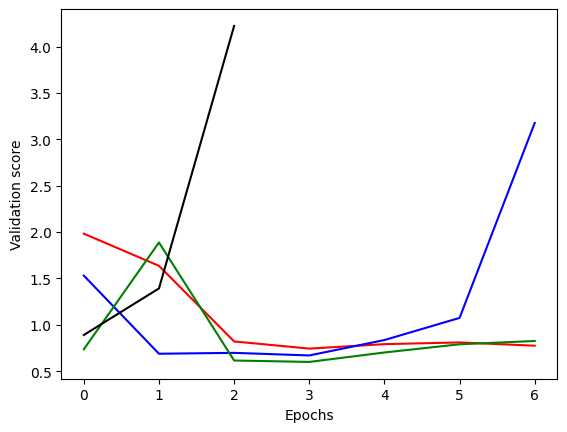

In [21]:
# Create the plot
plt.plot(model1_training.history['val_loss'], 'r', model2_training.history['val_loss'], 'b',
         model3_training.history['val_loss'], 'g', model4_training.history['val_loss'], 'black')
plt.xlabel('Epochs')
plt.ylabel('Validation score')

# Save the plot with high resolution
plt.savefig("train_performance.png", dpi=600, bbox_inches="tight")

plt.show()

# **Model 3 Test Performance**

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
AUC: 0.7329


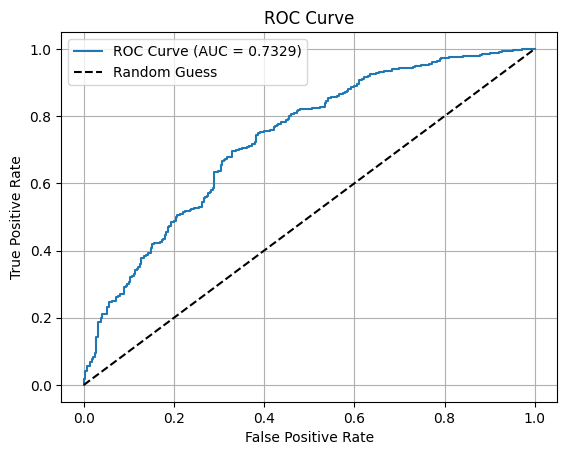

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# -------------------- Predictions --------------------
# Get predicted probabilities
y_pred_probs = model3.predict(X_test)  # Probability scores

# Get predicted classes
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# True classes
y_true_classes = np.argmax(y_test, axis=1)

# -------------------- AUC and ROC Curve --------------------
# Compute AUC score
auc_score = roc_auc_score(y_true_classes, y_pred_probs[:, 1])
print(f"AUC: {auc_score:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true_classes, y_pred_probs[:, 1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()

# Save the plot with high resolution
plt.savefig("AUC_model3.png", dpi=600, bbox_inches="tight")

plt.show()

Confusion Matrix:
[[126 164]
 [ 61 388]]


<Figure size 640x480 with 0 Axes>

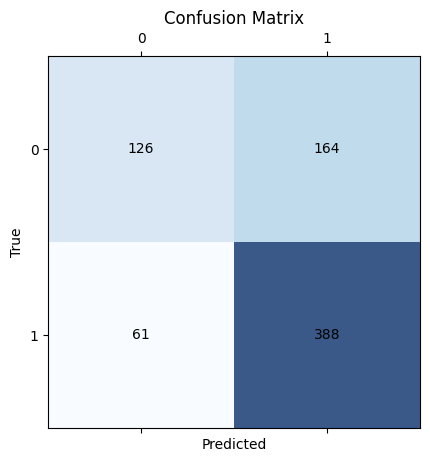

Classification Report:
                precision    recall  f1-score   support

 Class 0 (low)       0.67      0.43      0.53       290
Class 1 (high)       0.70      0.86      0.78       449

      accuracy                           0.70       739
     macro avg       0.69      0.65      0.65       739
  weighted avg       0.69      0.70      0.68       739

Precision: 0.7029
Recall: 0.8641
F1-Score: 0.7752


In [23]:
# -------------------- Confusion Matrix --------------------
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(f"Confusion Matrix:\n{conf_matrix}")

# Visualize confusion matrix
plt.figure()
plt.matshow(conf_matrix, cmap="Blues", alpha=0.8)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i, s=conf_matrix[i, j], ha="center", va="center")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# -------------------- Classification Metrics --------------------
# Generate classification report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=["Class 0 (low)", "Class 1 (high)"])
print("Classification Report:")
print(class_report)

# Compute precision, recall, and F1-score manually
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# **Model3 SHAP analysis**
https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability

In [24]:
import pandas as pd
import numpy as np
import shap

# ... your existing code ...

# Before initializing the SHAP explainer, ensure X_train has the correct data type:
# If your model was trained with a pandas DataFrame, use this:
X_train_numeric = X_train.astype(np.float32)  # Ensure all columns are numeric type

# If your model was trained with a NumPy array, you may skip this step.

# Initialize the SHAP explainer with the correctly formatted data:
explainer = shap.Explainer(model3, X_train_numeric)

# Compute SHAP values:
shap_values = explainer(X_train_numeric)

PermutationExplainer explainer: 2954it [05:48,  8.32it/s]


### **Summary plot**

In [25]:
# Ensure all columns in X_train are numeric
X_train = X_train.apply(pd.to_numeric, errors="coerce")

# Confirm no NaN values exist after conversion
if X_train.isnull().any().any():
    print("Warning: Missing values detected!")
    print(X_train.isnull().sum())
else:
    print("No missing values in X_train after conversion.")

No missing values in X_train after conversion.


In [26]:
# Ensure feature names are explicitly extracted
feature_names = X_train.columns.tolist()
print("Feature Names:", feature_names)

Feature Names: ['distance', 'head', 'age', 'meanbw', 'temp', 'timetrans_min', 'lairagetime', 'season_summer', 'season_winter', 'timegr_morning', 'timegr_night']


In [27]:
# Convert X_train to NumPy array
X_train_np = X_train.values
print("X_train_np shape:", X_train_np.shape)

X_train_np shape: (2953, 11)


In [28]:
# Debug SHAP values
print(f"SHAP Values Shape: {shap_values.values.shape}")

SHAP Values Shape: (2953, 11, 2)


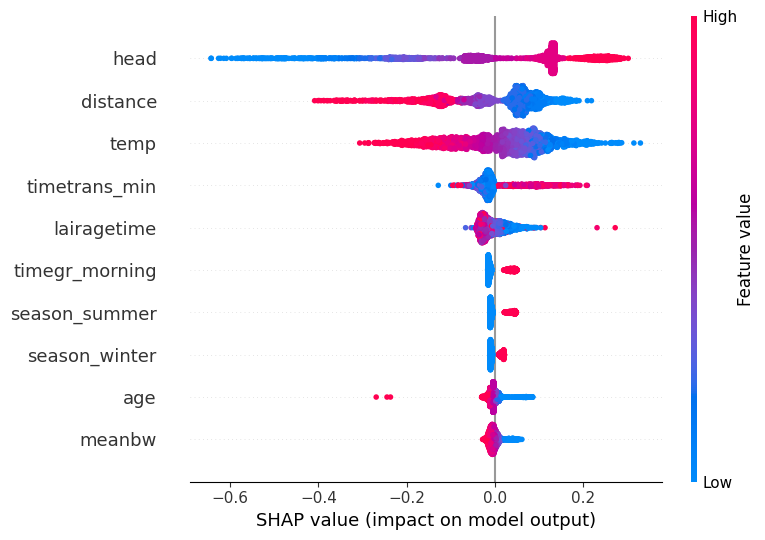

In [29]:
# Select SHAP values for the 'high' class (class index 1)
shap_values_high = shap_values.values[:, :, 1]

import shap
import matplotlib.pyplot as plt

# Generate the SHAP beeswarm plot
shap.summary_plot(
    shap_values_high,
    X_train_np,
    feature_names=feature_names,
    max_display=10,
    show=False  # Do not display immediately
)

# Save the plot with high resolution
plt.savefig("shap_summary_plot_beeswarm.png", dpi=600, bbox_inches="tight")
plt.show()

### **Bar plot**

SHAP values for class 'high': (2953, 11)


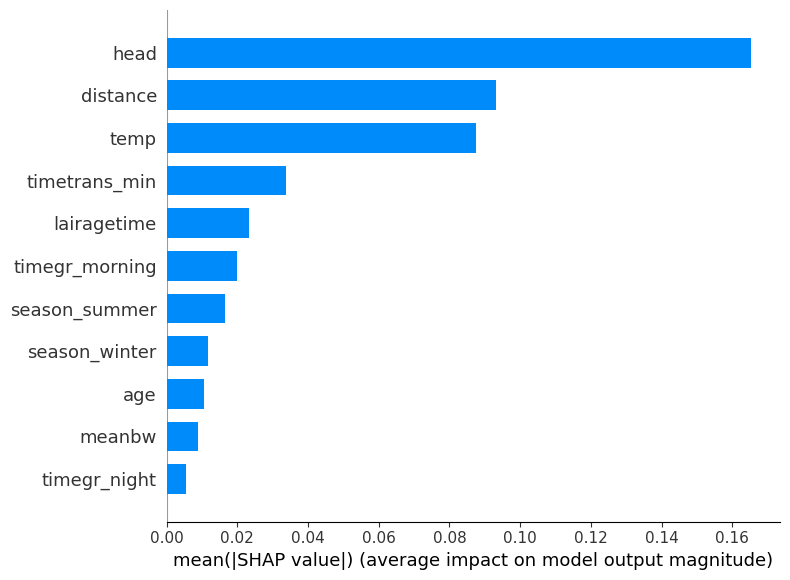

In [30]:
# Select SHAP values for the 'high' class (class index 1)
shap_values_class_high = shap_values[:, :, 1]  # Extract SHAP values for class 1

# Verify the shape
print(f"SHAP values for class 'high': {shap_values_class_high.shape}")  # Should be (2953, 11)

# Generate the bar plot for feature importance
shap.summary_plot(shap_values_class_high, X_train_np, plot_type="bar", feature_names=feature_names, show=False)

# Save the plot with high resolution
plt.savefig("shap_bar_plot.png", dpi=600, bbox_inches="tight")
plt.show()

### **Dependence plot**

In [31]:
pip install shap --upgrade

### **Select top 5 important variables**
head, temp, timetrans_min, distance, lairagetime

In [32]:
X_train_np = np.array(X_train_np, dtype=float)  # Ensure features are numeric
shap_values_high = np.array(shap_values_high)   # Ensure SHAP values are numeric

<Figure size 640x480 with 0 Axes>

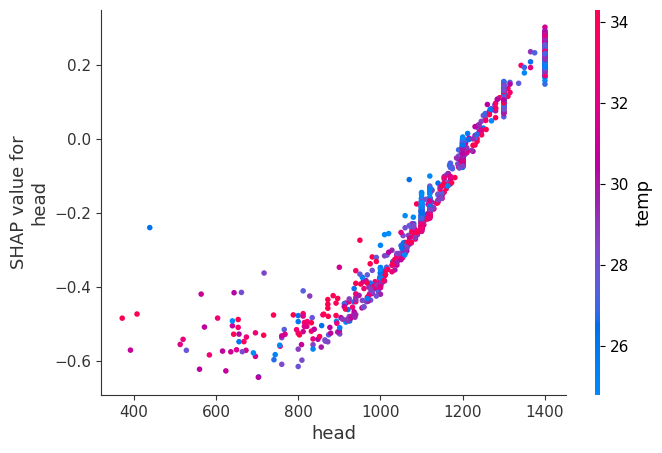

In [33]:
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=1,  # Feature index for 'head'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_np,  # Feature dataset
        feature_names=feature_names,  # List of feature names
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_head.png", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

<Figure size 640x480 with 0 Axes>

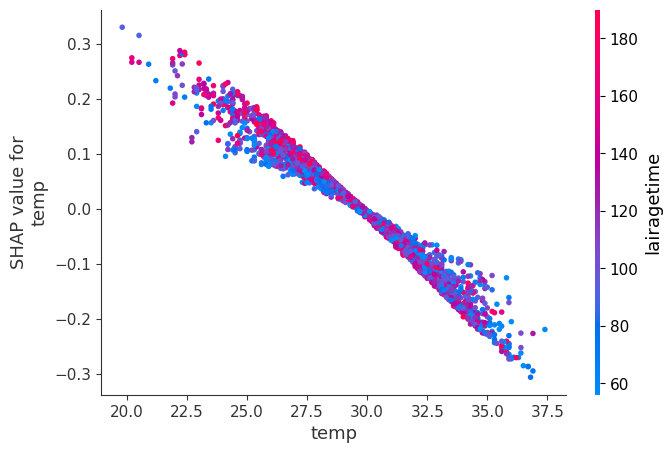

In [34]:
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=4,  # Feature index for 'temp'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_np,  # Feature dataset
        feature_names=feature_names,  # List of feature names
        interaction_index=6,
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_temp.png", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

<Figure size 640x480 with 0 Axes>

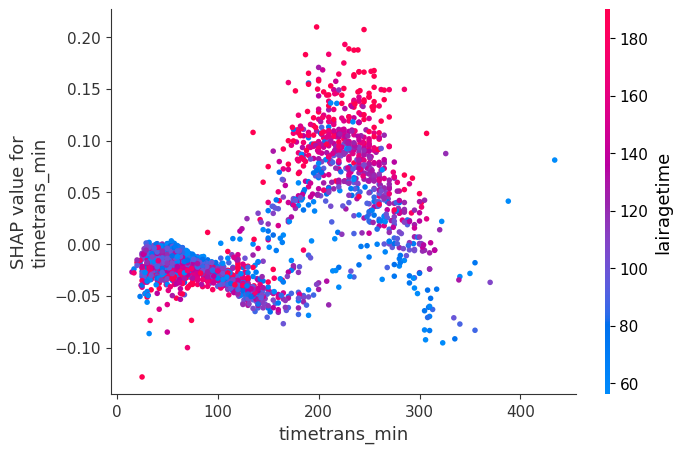

In [35]:
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=5,  # Feature index for 'timetrans_min'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_np,  # Feature dataset
        feature_names=feature_names,  # List of feature names
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_timetrans_min.png", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

<Figure size 640x480 with 0 Axes>

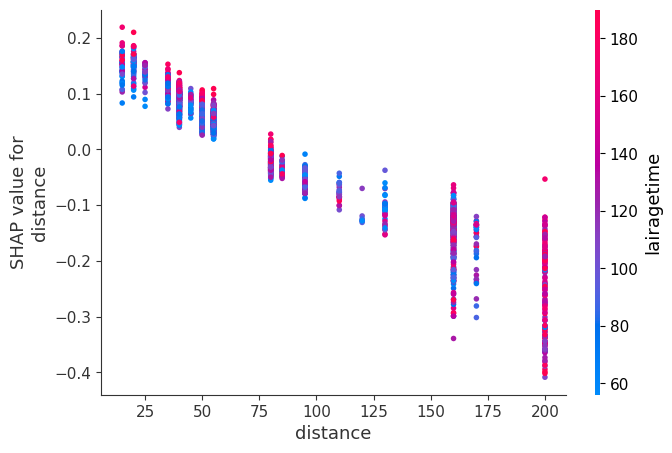

In [38]:
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=0,  # Feature index for 'distance'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_np,  # Feature dataset
        feature_names=feature_names,  # List of feature names
        interaction_index=6,
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_distance.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

<Figure size 640x480 with 0 Axes>

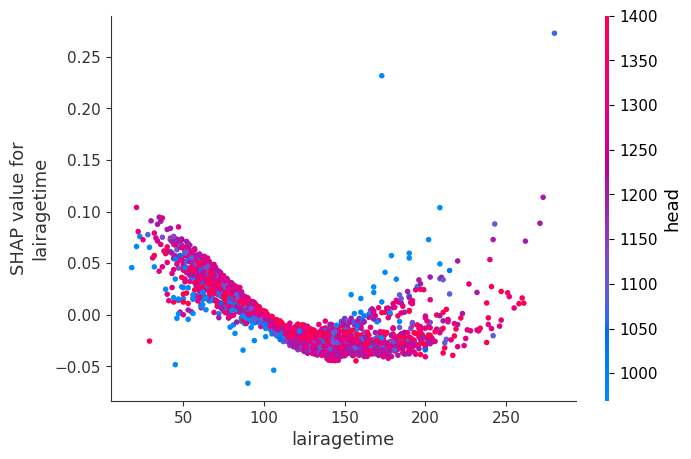

In [39]:
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=6,  # Feature index for 'lairagetime'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_np,  # Feature dataset
        feature_names=feature_names,  # List of feature names
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_lairagetime.png", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

### **Force plot**

In [44]:
# Calculate the expected value (mean prediction for the 'high' class)
expected_value = np.mean(model3.predict(X_train_numeric)[:, 1])  # Mean probability for the 'high' class

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step


In [46]:
import shap

shap.initjs()  # Initialize JavaScript visualization

### **Force plot for lowest doapct instance**
instance 1 (index = 0), doapct = 0

In [47]:
import shap
import matplotlib.pyplot as plt

# Select one instance to explain (e.g., the first row of your dataset)
instance_index = 0  # Replace with the row index you want to visualize
shap_values_single_0 = shap_values.values[instance_index, :, 1]  # SHAP values for 'high' class
features_single_0 = X_train_np[instance_index, :]  # Feature values for the selected instance

# Generate the force plot
shap.initjs()  # Initialize JavaScript for visualization
force_plot_0 = shap.force_plot(
    base_value=expected_value,  # Manually calculated expected value
    shap_values=shap_values_single_0,  # SHAP values for the selected instance
    features=features_single_0,  # Feature values for the selected instance
    feature_names=feature_names  # Feature names
)

# Display the plot
force_plot_0

In [48]:
import shap

# Save the force plot as an HTML file
shap.save_html("force_plot_instance_0.html", force_plot_0)

# If using Google Colab, download the file to your local machine
from google.colab import files
files.download("force_plot_instance_0.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

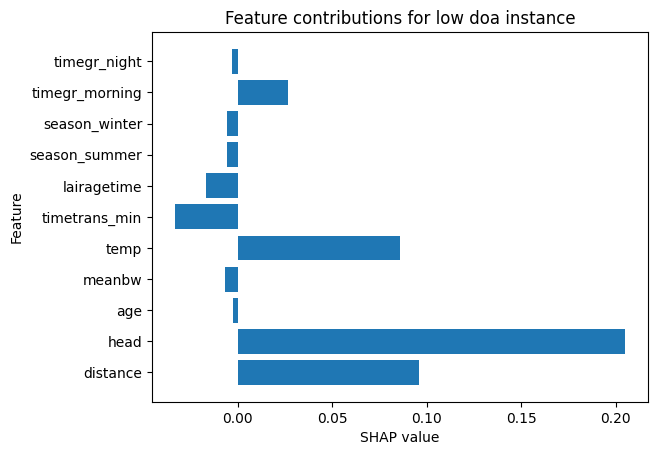

In [49]:
import matplotlib.pyplot as plt

# Plot the SHAP values for a single instance as a horizontal bar plot
plt.barh(feature_names, shap_values_single_0)
plt.xlabel("SHAP value")
plt.ylabel("Feature")
plt.title("Feature contributions for low doa instance")

# Save the plot with high resolution
plt.savefig("feat_contribute_low.png", dpi=600, bbox_inches="tight")

plt.show()

## **Force plot for highest doapct instance**

In [50]:
highest_doapct_index = df['doapct'].idxmax()  # Index of the instance with the highest doapct

In [54]:
instance_to_explain = X_train.iloc[highest_doapct_index, :]

In [56]:
import shap
import matplotlib.pyplot as plt

# Select the SHAP values for the identified instance
shap_values_single = shap_values.values[highest_doapct_index, :, 1]  # SHAP values for the 'high' class
features_single = X_train_np[highest_doapct_index, :]  # Feature values for the selected instance

# Generate the force plot
shap.initjs()  # Initialize JavaScript for visualization
force_plot = shap.force_plot(
    base_value=expected_value,  # Manually calculated expected value
    shap_values=shap_values_single,  # SHAP values for the selected instance
    features=features_single,  # Feature values for the selected instance
    feature_names=feature_names  # Feature names
)

# Display the plot
force_plot

In [57]:
import shap

# Save the force plot as an HTML file
shap.save_html("force_plot_highest_doa.html", force_plot)

# If using Google Colab, download the file to your local machine
from google.colab import files
files.download("force_plot_highest_doa.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

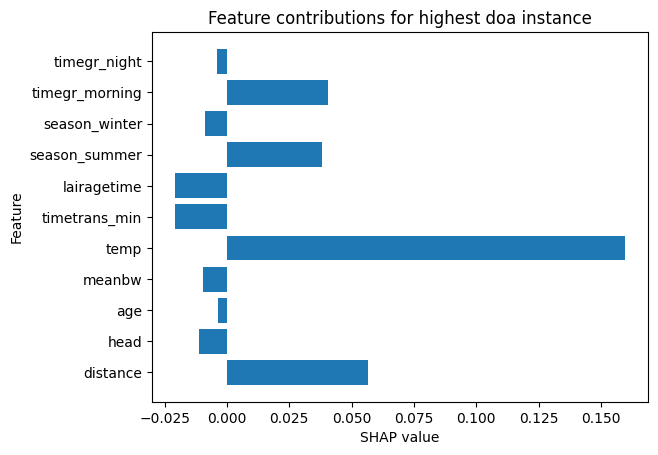

In [58]:
import matplotlib.pyplot as plt

# Plot the SHAP values for a single instance as a horizontal bar plot
plt.barh(feature_names, shap_values_single)
plt.xlabel("SHAP value")
plt.ylabel("Feature")
plt.title("Feature contributions for highest doa instance")

# Save the plot with high resolution
plt.savefig("feat_contribute_highest.png", dpi=600, bbox_inches="tight")

plt.show()

### **Decision plot**

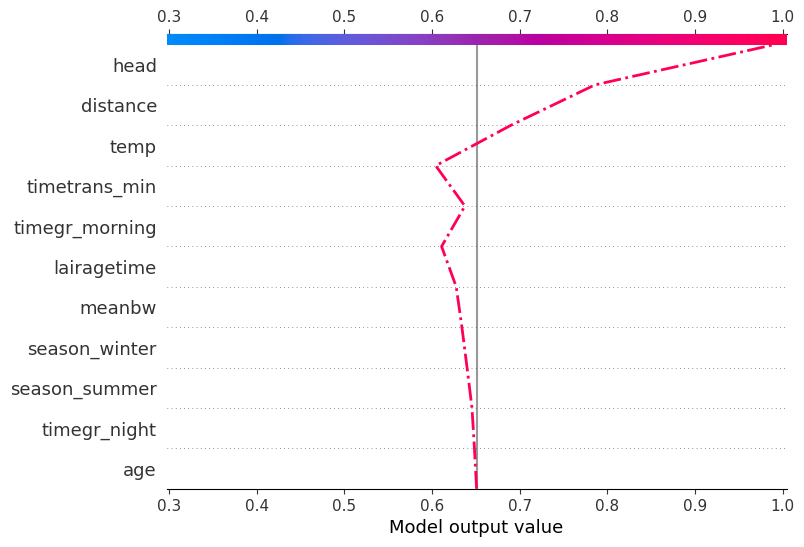

<Figure size 640x480 with 0 Axes>

In [59]:
import shap
import matplotlib.pyplot as plt

# Select an instance to explain (e.g., the first row)
instance_index = 0  # Replace with the desired row index

# Generate a decision plot
shap.decision_plot(
    base_value=expected_value,                # Manually calculated expected value
    shap_values=shap_values.values[instance_index, :, 1],  # SHAP values for the 'high' class
    feature_names=feature_names,             # Feature names
    feature_order="importance",              # Optional: Order features by importance
    highlight=0                              # Optional: Highlight the selected instance
)

# Save the plot with high resolution
plt.savefig("decision_plot_lowdoa.png", dpi=600, bbox_inches="tight")

# Display the plot
plt.show()

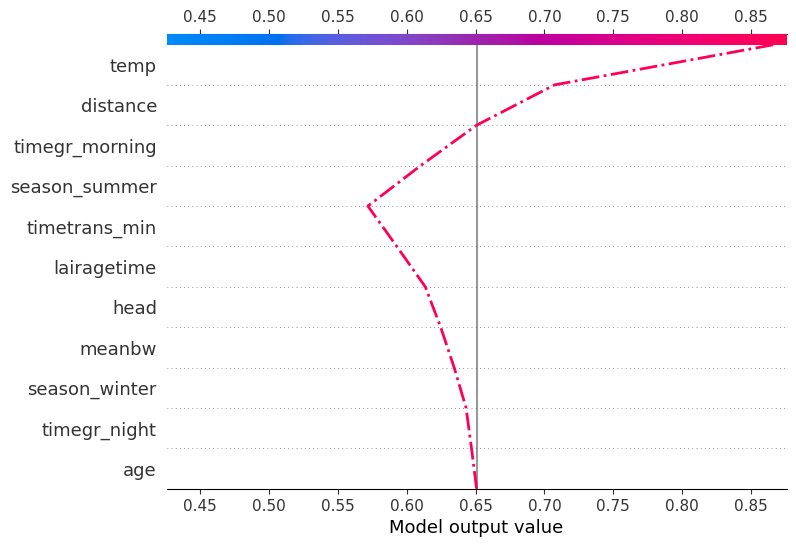

<Figure size 640x480 with 0 Axes>

In [60]:
import shap
import matplotlib.pyplot as plt

# Select an instance to explain (e.g., the first row)
# highest_doapct_index

# Generate a decision plot
shap.decision_plot(
    base_value=expected_value,                # Manually calculated expected value
    shap_values=shap_values.values[highest_doapct_index, :, 1],  # SHAP values for the 'high' class
    feature_names=feature_names,             # Feature names
    feature_order="importance",              # Optional: Order features by importance
    highlight=0                              # Optional: Highlight the selected instance
)

# Save the plot with high resolution
plt.savefig("decision_plot_highest_doa.png", dpi=600, bbox_inches="tight")

# Display the plot
plt.show()

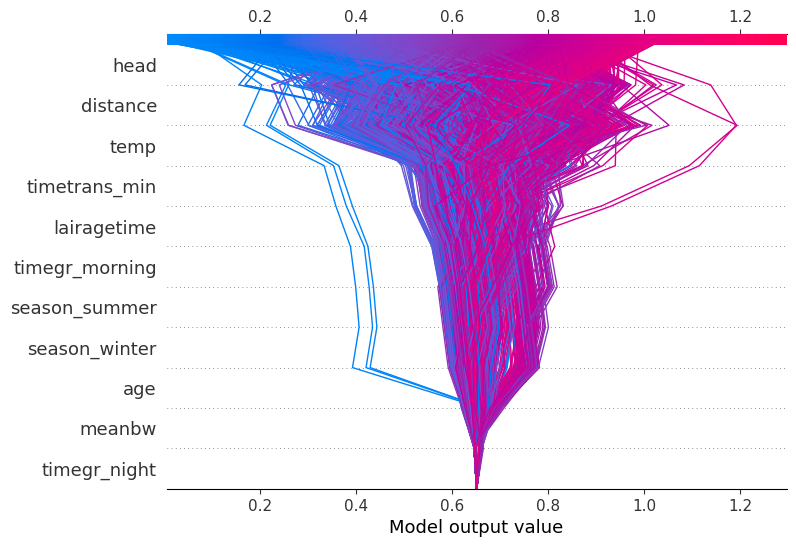

<Figure size 640x480 with 0 Axes>

In [61]:
import shap
import matplotlib.pyplot as plt

# Generate a decision plot for all instances
shap.decision_plot(
    base_value=expected_value,                # Manually calculated expected value
    shap_values=shap_values.values[:, :, 1],  # SHAP values for the 'high' class (all instances)
    feature_names=feature_names,             # Feature names
    feature_order="importance",              # Order features by importance
    ignore_warnings=True                     # Ignore warnings about large datasets
)

# Save the plot with high resolution
plt.savefig("decision_plot_all_instance.png", dpi=600, bbox_inches="tight")

plt.show()

### **Add plot of neural networks architecture**

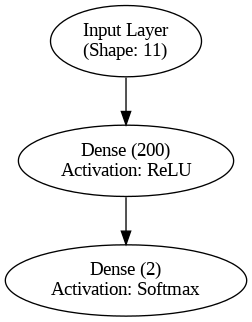

In [62]:
from graphviz import Digraph

# Create a directed graph
dot = Digraph()

# Add nodes for the layers in your model
dot.node("Input", "Input Layer\n(Shape: {})".format(X_train.shape[1]))  # Input layer with feature count
dot.node("Dense1", "Dense (200)\nActivation: ReLU")  # First dense layer
dot.node("Output", "Dense (2)\nActivation: Softmax")  # Output layer

# Add edges to represent connections between layers
dot.edge("Input", "Dense1")  # Connect Input to Dense1
dot.edge("Dense1", "Output")  # Connect Dense1 to Output

# Render the architecture
dot.render("model3_b_architecture", format="png", cleanup=True)

# Display the generated PNG (for Google Colab or Jupyter)
from IPython.display import Image
Image("model3_b_architecture.png")

In [63]:
!pip install matplotlib
!pip install graphviz

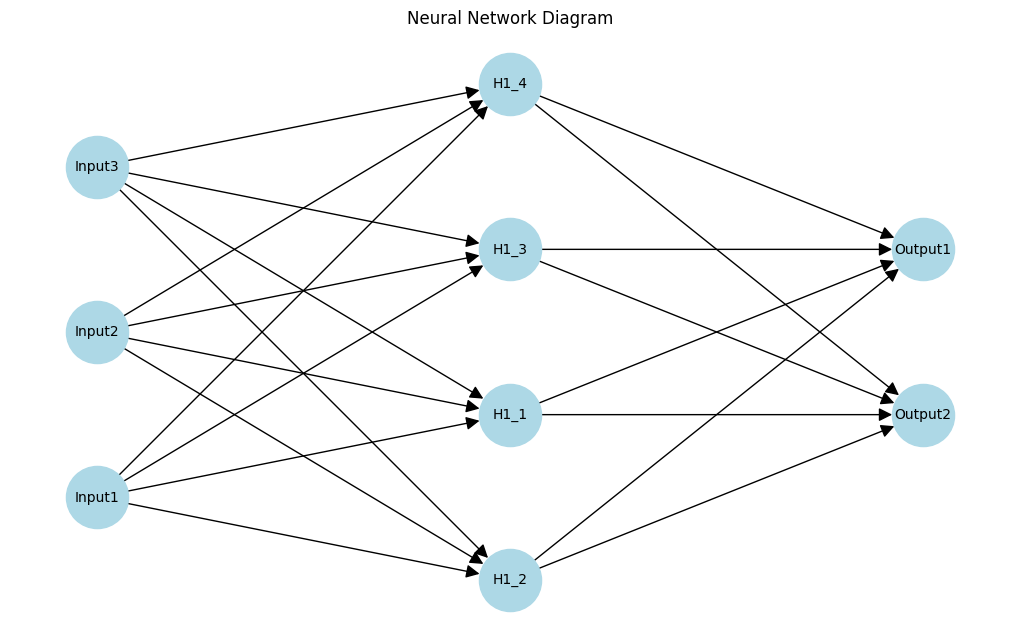

In [64]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Define layers
input_layer = ["Input1", "Input2", "Input3"]
hidden_layer = ["H1_1", "H1_2", "H1_3", "H1_4"]
output_layer = ["Output1", "Output2"]

# Add nodes for each layer
G.add_nodes_from(input_layer, layer=0)
G.add_nodes_from(hidden_layer, layer=1)
G.add_nodes_from(output_layer, layer=2)

# Add edges (connections between layers)
for input_node in input_layer:
    for hidden_node in hidden_layer:
        G.add_edge(input_node, hidden_node)
for hidden_node in hidden_layer:
    for output_node in output_layer:
        G.add_edge(hidden_node, output_node)

# Create a layout for the nodes
pos = nx.multipartite_layout(G, subset_key="layer")

# Draw the graph
plt.figure(figsize=(10, 6))
nx.draw(
    G, pos, with_labels=True, node_size=2000, node_color="lightblue", arrowsize=20, font_size=10
)
plt.title("Neural Network Diagram")
plt.show()


### **Keras Visualizer Library**
https://colab.research.google.com/drive/1S35LDBXLV89nAfOvOURJJsbGpC49nFGG?usp=sharing#scrollTo=FDYJdvI5VJ4L&uniqifier=1

In [65]:
!pip3 install keras-visualizer

  Using cached keras_visualizer-3.2.0-py3-none-any.whl.metadata (7.6 kB)


In [66]:
from keras import models
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation
from keras_visualizer import visualizer
from keras import layers

In [67]:
from tensorflow.keras import models, layers
from keras_visualizer import visualizer
from PIL import Image

# Define your model
model = models.Sequential([
    layers.Input(shape=(11,)),  # Input layer with 11 features
    layers.Dense(200, activation='relu'),  # Hidden layer with 200 neurons
    layers.Dense(2, activation='softmax')  # Output layer with 2 neurons
])

# Visualize the model
visualizer(model, file_name='/content/nnarchitect', file_format='png', view=False)

# **Save files & Make the work reproducible**
remove # for running the code

In [68]:
#!pip freeze > requirements.txt

In [69]:
#from google.colab import files
#files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [70]:
#os.listdir()

In [74]:
#!zip -r project_baseline.zip *

  adding: AUC_model3.png (deflated 24%)
  adding: decision_plot_all_instance.png (deflated 99%)
  adding: decision_plot_highest_doa.png (deflated 99%)
  adding: decision_plot_lowdoa.png (deflated 99%)
  adding: dependence_distance.jpg (deflated 52%)
  adding: dependence_head.png (deflated 11%)
  adding: dependence_lairagetime.png (deflated 11%)
  adding: dependence_temp.png (deflated 9%)
  adding: dependence_timetrans_min.png (deflated 6%)
  adding: DOA-managed.xlsx (deflated 1%)
  adding: feat_contribute_highest.png (deflated 31%)
  adding: feat_contribute_low.png (deflated 31%)
  adding: force_plot_highest_doa.html (deflated 68%)
  adding: force_plot_instance_0.html (deflated 68%)
  adding: model3_b_architecture.png (deflated 8%)
  adding: nnarchitect (deflated 76%)
  adding: nnarchitect.png (deflated 6%)
  adding: project.zip (stored 0%)
  adding: requirements.txt (deflated 56%)
  adding: sample_data/ (stored 0%)
  adding: sample_data/README.md (deflated 39%)
  adding: sample_data/a

In [75]:
#from google.colab import files
#files.download("project_baseline.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Reproduce the Environment**

In [ ]:
#pip install -r requirements.txt


### ▶ ALL DONE ◀



